In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon May 30 22:09:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |  10276MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 44%   

In [3]:
from dataset import Dataset
from torch.utils.data import DataLoader

dataset = Dataset('/data/image/images256x256', 256)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [4]:
from utils import sizeof_fmt, Logger

!mkdir save
save_dir = 'save/train1'
logger = Logger(save_dir=save_dir, new=True)
!ls $save_dir
print('done')

mkdir: cannot create directory ‘save’: File exists
data.json  save_0  save_1047
done


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from glide_text2im.unet import UNetModel
from glide_text2im.gaussian_diffusion import get_named_beta_schedule, GaussianDiffusion

In [6]:
model = UNetModel(in_channels=3,
                 model_channels=64,
                 out_channels=3,
                 num_res_blocks=2,
                 attention_resolutions=())
model = model.cuda()

betas = get_named_beta_schedule("squaredcos_cap_v2", 1000)
diffusion = GaussianDiffusion(betas=betas)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

if True:
    model, optimizer, step = logger.load(1047, model, optimizer)

print('done')

Model size 215.8MiB
loaded : 1047
done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


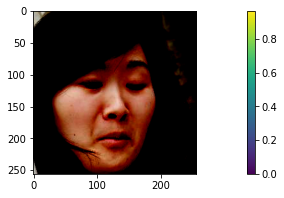

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


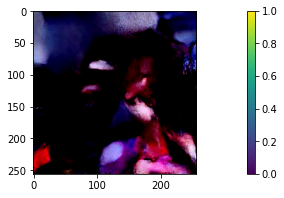

step : 2010 loss : 0.0756
step : 2020 loss : 0.2096
step : 2030 loss : 0.1113
step : 2040 loss : 0.0836


In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

while(True):
    for batch in train_loader:
        
        model.train()
        model.zero_grad()
        
        batch = batch.cuda()
        loss = diffusion.forward(model=model, img=batch)
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        if torch.isnan(grad_norm.mean()):
            print(grad_norm)
            continue
        
        optimizer.step()
                
        if step % 10 == 0:
            print('step :', step, 
                  'loss :', '%0.4f' % loss.item())
        
        if step % 100 == 0:
            logger.log(step, 'loss', loss.item())
            
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
                  
        if step % 1000 == 0:
            display.clear_output()
            with torch.no_grad():
                samples = diffusion.p_sample_loop(model, (1, 3, 256, 256))
            
            plt.figure(figsize=[18, 3])
            _x = batch[0].permute(1, 2, 0).data.cpu().numpy()
            plt.imshow(_x)
            plt.colorbar()
            plt.show()

            plt.figure(figsize=[18, 3])
            _y = samples[0].permute(1, 2, 0).data.cpu().numpy()
            plt.imshow(_y)
            plt.colorbar()
            plt.show()
            
        step += 1
            

In [ ]:
logger.save(step, model, optimizer)